<h1>День 4. Отток.</h1>

<h3>Сервисный модуль</h3>
<b><i>Пожалуйста, запустите следующие несколько ячеек при первом запуске ноутбука!</i></b>

In [255]:
import warnings
warnings.filterwarnings('ignore')

In [256]:
%pip install -r '/home/jupyter/work/resources/a2nced/requirements.txt'

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 427 kB 1.6 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [257]:
import os
import sys
from pathlib import Path
dir_path = Path(os.getcwd()).resolve().parent.as_posix()
sys.path.append(dir_path)

<h3>Конец сервисного модуля</h3>

In [258]:
import datetime as dt
import numpy as np
import pandas as pd

In [259]:
_PATH = '/home/jupyter/mnt/s3/course-test/day_4/'

In [260]:
orders_path       = os.path.join(_PATH, 'day_4_orders.csv') # информация о заказах, сгруппированная по корзинам
demographics_path = os.path.join(_PATH, 'day_4_demogr.csv') # информация о клиентах

In [261]:
demographics = pd.read_csv(demographics_path)

In [262]:
orders_df = pd.read_csv(orders_path)
orders_df['purch_date_time'] = orders_df['purch_date_time'].astype(np.datetime64)
orders_df.head()

user_id    basket_id     purch_date_time  quantity  sales_value  \
0        1  27601281299 2018-09-19 15:56:00        34        78.66   
1        1  27774192959 2018-10-05 21:02:00        14        41.10   
2        1  28024266849 2018-10-26 17:04:00        13        26.90   
3        1  28106322445 2018-11-01 20:37:00        32        63.43   
4        1  28235481967 2018-11-08 17:03:00        20        53.45   

   retail_disc  default_price  
0       -16.54          96.20  
1        -8.59          49.69  
2        -6.72          33.62  
3       -11.08          76.51  
4       -16.42          69.87

<br>
<h1>Практика 1</h1>
<h3>Построение модели BetaGeoFitter</h3>
<br>

In [263]:
from lifetimes import BetaGeoFitter

from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_period_transactions

import matplotlib.pyplot as plt
import seaborn as sns

In [264]:
transaction_data = summary_data_from_transaction_data(transactions=orders_df,
                                                      customer_id_col='user_id',
                                                      datetime_col='purch_date_time',
                                                      monetary_value_col='sales_value',
                                                      freq='D')  

In [265]:
transaction_data.head()

frequency  recency      T  monetary_value
user_id                                           
1             78.0    655.0  661.0       54.506410
2             44.0    565.0  609.0       43.900909
3             45.0    590.0  599.0       57.920000
4             29.0    523.0  608.0       37.030000
5             32.0    618.0  627.0       24.205625

In [266]:
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(transaction_data['frequency'], 
        transaction_data['recency'], 
        transaction_data['T'])
bgf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r      0.990981  0.021868         0.948119         1.033843
alpha  7.122051  0.213029         6.704515         7.539587
a      0.003888  0.000546         0.002819         0.004957
b      0.263219  0.029235         0.205919         0.320519

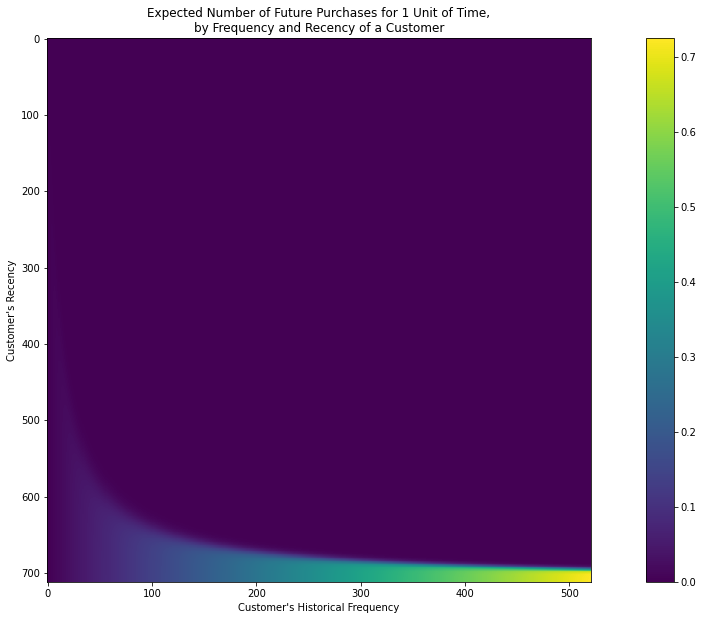

In [267]:
plt.figure(figsize=(20,10)) 
plot_frequency_recency_matrix(bgf)
plt.show()

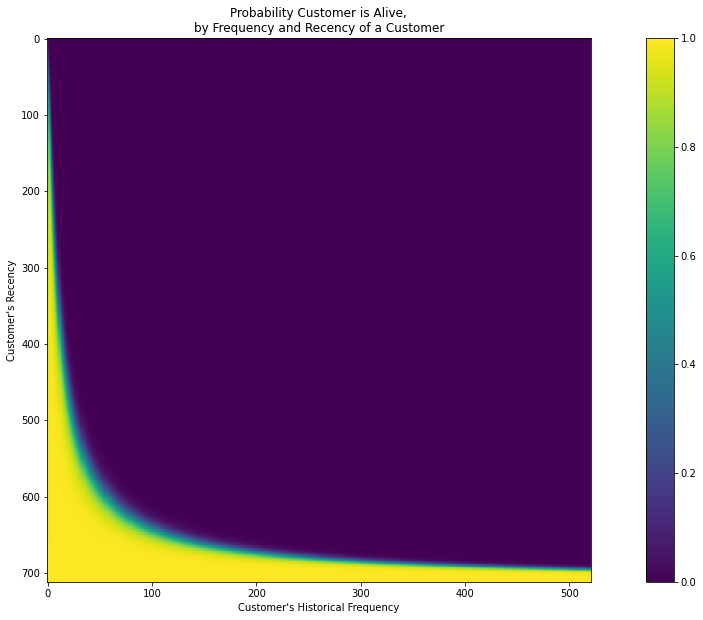

In [268]:
plt.figure(figsize=(20,10)) 
plot_probability_alive_matrix(bgf)
plt.show()

In [269]:
# ранжирование клиентов
t = 1
transaction_data['predicted_purchases'] = \
bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                        transaction_data['frequency'], 
                                                        transaction_data['recency'], 
                                                        transaction_data['T'])
transaction_data.sort_values(by='predicted_purchases').tail(5)

frequency  recency      T  monetary_value  predicted_purchases
user_id                                                                
762          440.0    625.0  626.0       20.402000             0.696519
2337         442.0    595.0  598.0       26.436742             0.732008
1795         489.0    622.0  623.0       19.940143             0.777597
1510         504.0    629.0  630.0       22.240813             0.792597
900          520.0    649.0  650.0       31.547212             0.792822

Способы оценки достоверности прогноза:
1) использовать сгенерированные данные и оценить качество работы на них.

<Figure size 1440x720 with 0 Axes>

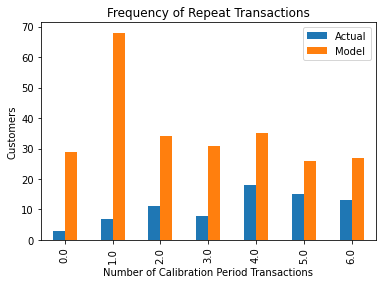

In [270]:
plt.figure(figsize=(20,10)) 
plot_period_transactions(bgf)
plt.show()

2) использовать обучающую и тестовую выборки

Для этого нам понадобится утилита calibration_and_holdout_data, которая умеет задавать границы обучающей и тестовой выборок (параметры calibration_period_end и observation_period_end соответственно)

In [271]:
summary_cal_holdout = calibration_and_holdout_data(transactions=orders_df,
                                                      customer_id_col='user_id',
                                                      datetime_col='purch_date_time',
                                                   calibration_period_end='2020-03-08',
                                                   observation_period_end='2020-04-14' )

<Figure size 1152x864 with 0 Axes>

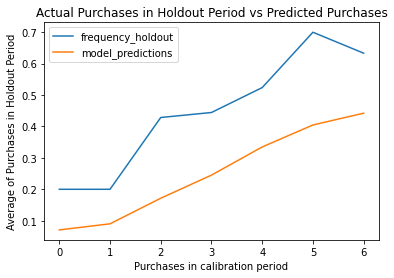

In [272]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plt.figure(figsize=(16,12)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show()

In [273]:
orders_df.sample()

user_id    basket_id     purch_date_time  quantity  sales_value  \
167901     1515  41848058004 2020-06-07 19:03:00         4        19.18   

        retail_disc  default_price  
167901          0.0          19.18

In [274]:
# такого покупателя мы нашнли специально: сначала заказывал часто, потом стал заказывать редко
customer_id = 1610

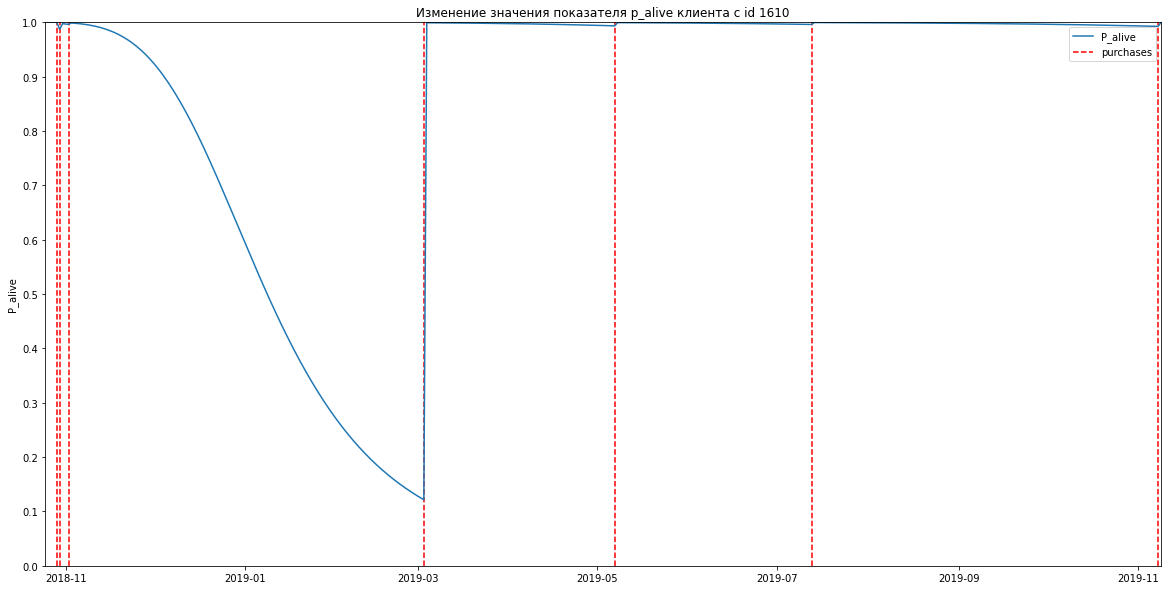

In [275]:
days_since_birth = 100
sp_trans = orders_df.loc[orders_df['user_id'] == customer_id]
plt.figure(figsize=(20,10)) 
plot_history_alive(bgf, days_since_birth, sp_trans, 'purch_date_time')
plt.title(f'Изменение значения показателя p_alive клиента с id {customer_id}')
plt.legend(loc=0)
plt.show()

<br>
<h1>Практика 2</h1>
<h3>Определение границ оттока</h3>
<br>

In [276]:
# выберем слуйную дату
due_day = dt.datetime.strptime('2019-07-15', '%Y-%m-%d')

In [277]:
# оставим только информцию по датам совершенных покупок
df = orders_df[['user_id', 'purch_date_time']].sort_values(['user_id', 'purch_date_time'])

In [278]:
# отфильтуем заказы, сделанные до этой даты и определеим интервалы для каждого пользователя
order_diff = df[df.purch_date_time <= due_day].groupby('user_id')['purch_date_time'].diff().rename('time_diff')

In [279]:
df = df.merge(order_diff, left_index=True, right_index=True)
df.head()

user_id     purch_date_time        time_diff
0        1 2018-09-19 15:56:00              NaT
1        1 2018-10-05 21:02:00 16 days 05:06:00
2        1 2018-10-26 17:04:00 20 days 20:02:00
3        1 2018-11-01 20:37:00  6 days 03:33:00
4        1 2018-11-08 17:03:00  6 days 20:26:00

In [280]:
# удалим первые заказы (перед которыми нет интервала) округлим интервалы до целых дней
orders_df_no_na = df.dropna(subset=['time_diff'])
orders_df_no_na['day_diff'] = np.round_(orders_df_no_na['time_diff'] / np.timedelta64(1, 'D'))
orders_df_no_na.head()

user_id     purch_date_time        time_diff  day_diff
1        1 2018-10-05 21:02:00 16 days 05:06:00      16.0
2        1 2018-10-26 17:04:00 20 days 20:02:00      21.0
3        1 2018-11-01 20:37:00  6 days 03:33:00       6.0
4        1 2018-11-08 17:03:00  6 days 20:26:00       7.0
5        1 2018-11-15 16:13:00  6 days 23:10:00       7.0

<AxesSubplot:xlabel='day_diff', ylabel='Count'>

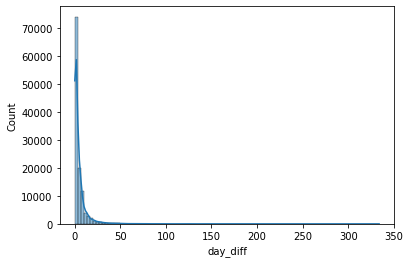

In [281]:
# построим диаграмму, чтобы понять, какие интевалы между покупками характерны для наших клиентов
sns.histplot(orders_df_no_na, x='day_diff', bins=100, kde=True)

Text(0.5, 1.0, 'Паттерн: регулярные нечастые покупки')

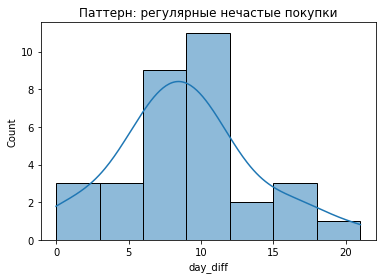

In [282]:
# а теперь для отдельных клиентов
sns.histplot(orders_df_no_na[orders_df_no_na['user_id'] == 1], x='day_diff', kde=True).set_title('Паттерн: регулярные нечастые покупки')

Text(0.5, 1.0, 'Паттерн: регулярные частые покупки')

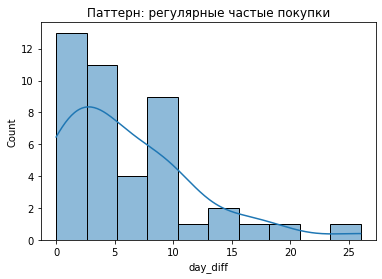

In [283]:
sns.histplot(orders_df_no_na[orders_df_no_na['user_id'] == 2499], x='day_diff', bins=10, kde=True).set_title('Паттерн: регулярные частые покупки')

In [284]:
# для каждого пользователя посчитаем, сколько у него было интервалов без покупок и каких
num_days_diff = pd.DataFrame()
num_days_diff['user_id'] = orders_df_no_na.user_id.values

In [285]:
# учитываем только перерывы больше одного дня (т.е две и более совершенных за день покупок = одна транзакция)
for day in range(1, 11):
    if day == 10:
        diff_df = orders_df_no_na[orders_df_no_na.day_diff >= day]\
        [['user_id', 'day_diff']].groupby('user_id').count().reset_index().rename({'day_diff':'>=10'}, axis=1)
    else:
        diff_df = orders_df_no_na[orders_df_no_na.day_diff == day]\
        [['user_id', 'day_diff']].groupby('user_id').count().reset_index().rename({'day_diff':f'{day}'}, axis=1)
    num_days_diff = num_days_diff.merge(diff_df, how='left', on='user_id')
    
    
num_days_diff.fillna(0, inplace=True)
num_days_diff.drop_duplicates(inplace=True, ignore_index=True) # не забудем избавиться от дубликатов, которые возникают из-за разных индексов
num_days_diff = num_days_diff.astype('int')

In [286]:
num_days_diff.head()

user_id  1  2  3  4  5  6  7  8  9  >=10
0        1  0  1  1  0  2  3  3  3  5    12
1        2  4  0  4  2  1  1  3  0  1    11
2        3  2  2  3  3  2  2  1  2  1     8
3        4  0  0  1  2  0  0  1  1  1    11
4        5  1  2  0  0  1  0  1  0  2    10

In [287]:
# теперь определим долю простоев, равных или больших данному интервалу
share_days_diff = pd.DataFrame()
share_days_diff['user_id'] = num_days_diff.user_id
for day in range(2, 10):
    column = f'share_>={day}'
    share_days_diff[column] = (num_days_diff.iloc[:, day:].sum(axis=1) / num_days_diff.iloc[:, 1:].sum(axis=1)).values

share_days_diff.head()

user_id  share_>=2  share_>=3  share_>=4  share_>=5  share_>=6  share_>=7  \
0        1   1.000000   0.966667   0.933333   0.933333   0.866667   0.766667   
1        2   0.851852   0.851852   0.703704   0.629630   0.592593   0.555556   
2        3   0.923077   0.846154   0.730769   0.615385   0.538462   0.461538   
3        4   1.000000   1.000000   0.941176   0.823529   0.823529   0.823529   
4        5   0.941176   0.823529   0.823529   0.823529   0.764706   0.764706   

   share_>=8  share_>=9  
0   0.666667   0.566667  
1   0.444444   0.444444  
2   0.423077   0.346154  
3   0.764706   0.705882  
4   0.705882   0.705882

<br>
<h1>Практика 3</h1>
<h3>Другие способы определения границ оттока</h3>
<br>

In [288]:
# опеделим, сколько времени прошло (в днях) с момента последнего заказа
dates = orders_df_no_na.groupby('user_id')['purch_date_time'].max().reset_index()
dates.rename(columns={'purch_date_time': 'last_order'}, inplace=True)
dates['open_interval'] = np.round_((due_day - dates['last_order']) / np.timedelta64(1, 'D'))
dates['mean_interval'] = orders_df_no_na.groupby('user_id')['day_diff'].mean().reset_index(drop=True)

In [289]:
dates.head(10)

user_id          last_order  open_interval  mean_interval
0        1 2019-07-02 15:06:00           12.0       8.937500
1        2 2019-07-10 20:34:00            4.0       8.962963
2        3 2019-06-15 20:09:00           29.0       7.666667
3        4 2019-07-06 20:37:00            8.0      13.882353
4        5 2019-06-29 21:01:00           15.0      11.857143
5        6 2019-07-13 14:35:00            1.0       2.410526
6        7 2019-06-28 22:39:00           16.0      17.222222
7        8 2019-07-13 12:23:00            1.0       6.431818
8        9 2019-07-05 14:42:00            9.0      39.333333
9       10 2018-12-17 15:36:00          209.0       5.200000

In [290]:
# Создадим дубликат и разметим отток
churn_pred = dates.copy()

<h4>Подход 1: Просто оцениваем статистическую значимость простоя</h4>

In [291]:
churn_pred.head()

user_id          last_order  open_interval  mean_interval
0        1 2019-07-02 15:06:00           12.0       8.937500
1        2 2019-07-10 20:34:00            4.0       8.962963
2        3 2019-06-15 20:09:00           29.0       7.666667
3        4 2019-07-06 20:37:00            8.0      13.882353
4        5 2019-06-29 21:01:00           15.0      11.857143

In [292]:
import math
# напишем простую функцию, которая будет оценивать статистическую значимость простоя по отношению к среднему интервалу между покупками
def calc_value(frequency, recency):
    try:
        return(math.exp(-1 / frequency * recency))
    except ZeroDivisionError:
        return(np.nan)

In [293]:
# Создадим дубликат нашего датафрейма и разметим значимость простоя
churn_pred = dates.copy()

In [294]:
churn_pred['p_value'] = churn_pred.apply(lambda x: calc_value(x['mean_interval'],
                                                             x['open_interval']), axis=1)
churn_pred.head()

user_id          last_order  open_interval  mean_interval   p_value
0        1 2019-07-02 15:06:00           12.0       8.937500  0.261151
1        2 2019-07-10 20:34:00            4.0       8.962963  0.640004
2        3 2019-06-15 20:09:00           29.0       7.666667  0.022763
3        4 2019-07-06 20:37:00            8.0      13.882353  0.561990
4        5 2019-06-29 21:01:00           15.0      11.857143  0.282222

<h4>Подход 2: Используем взвешенную оценку для разметки оттока</h4>
<br>
<b><i>Логика: чем позже расположен на нашей временной шкале интервал, тем большее значение он имеет для предсказания текущего поведения пользователей пользователей (оно может меняться со временем)</i></b>

In [295]:
w_churn_pred = dates.copy()

In [296]:
# добавим в модель веса, чтобы недавние наблюдения имели большую значимость
intervals = dict()

for user_id in orders_df_no_na['user_id'].unique():
    intervals[user_id] = orders_df_no_na.loc[orders_df_no_na['user_id'] == user_id]['day_diff'].tolist()

In [297]:
def count_weighted_averages(x, interval_dict=intervals):
    intervals = interval_dict.get(x, [0,])
    pow_weights = [1 / (x + 1) ** 2 for x in range(len(intervals))]
    return(np.average(intervals, weights=pow_weights))

w_churn_pred['w_interval'] = w_churn_pred['user_id'].apply(lambda x: count_weighted_averages(x))
# применим уже известную нам функцию
w_churn_pred['w_p_value'] = w_churn_pred.apply(lambda x: calc_value(x['w_interval'],
                                                                           x['open_interval']),
                                               axis=1)

In [298]:
w_churn_pred.head()

user_id          last_order  open_interval  mean_interval  w_interval  \
0        1 2019-07-02 15:06:00           12.0       8.937500   14.836030   
1        2 2019-07-10 20:34:00            4.0       8.962963    7.529977   
2        3 2019-06-15 20:09:00           29.0       7.666667    8.399187   
3        4 2019-07-06 20:37:00            8.0      13.882353   28.308809   
4        5 2019-06-29 21:01:00           15.0      11.857143    3.838307   

   w_p_value  
0   0.445374  
1   0.587893  
2   0.031660  
3   0.753823  
4   0.020081

<h4>Подход 3: Бета-геометрическое распределение</h4>
<br>
<b><i>Логика: используем модель из предыдущего примера, которая оцеивает, насколько для пользователя критичен текущиц простой</i></b>

In [299]:
# данные нужно разметить. для этого в библиотеке lifetimes есть утилита summary_data_from_transaction_data
bgf_churn = summary_data_from_transaction_data(orders_df,
                                          'user_id', 'purch_date_time',
                                          observation_period_end=due_day)

In [300]:
# теперь используем модель для определения p-значения
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(bgf_churn['frequency'], bgf_churn['recency'], bgf_churn['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2497 subjects, a: 0.01, alpha: 8.84, b: 0.72, r: 1.25>


In [301]:
bgf_churn = bgf_churn.reset_index()

In [302]:
# посмотрим, насколько текущий открытый интервал статистически значим
bgf_churn['p_alive'] = bgf.conditional_probability_alive(bgf_churn['frequency'], bgf_churn['recency'], bgf_churn['T']+1)

In [303]:
bgf_churn.head()

user_id  frequency  recency      T   p_alive
0        1       30.0    286.0  299.0  0.998391
1        2       27.0    242.0  247.0  0.999180
2        3       26.0    207.0  237.0  0.983352
3        4       17.0    237.0  246.0  0.998610
4        5       17.0    249.0  265.0  0.997849

In [304]:
churn_probs = churn_pred[['user_id', 'p_value']].merge(w_churn_pred[['user_id', 'w_p_value']])
churn_probs = churn_probs.merge(bgf_churn[['user_id', 'p_alive']])

churn_probs.rename({'p_value':'p_basic',
                   'w_p_value':'p_weighted',
                   'p_alive':'p_bgf'}, axis=1, inplace=True)
churn_probs.head()

user_id   p_basic  p_weighted     p_bgf
0        1  0.261151    0.445374  0.998391
1        2  0.640004    0.587893  0.999180
2        3  0.022763    0.031660  0.983352
3        4  0.561990    0.753823  0.998610
4        5  0.282222    0.020081  0.997849

<h3>Бинаризация значимости</h3>

Разметим отток по следующему правилу

\begin{align}
churn = \begin{cases}
    1, & \text{if $p\_value<0.05$},\\
    0, & \text{otherwise}.
  \end{cases}
\end{align}

In [305]:
churn_probs['churn_basic'] = churn_probs.p_basic.apply(lambda x: 1 if x < 0.05 else 0)
churn_probs['churn_weighted'] = churn_probs.p_weighted.apply(lambda x: 1 if x < 0.05 else 0)
churn_probs['churn_bgf'] = churn_probs.p_bgf.apply(lambda x: 1 if x < 0.05 else 0)
churn_probs.head()

user_id   p_basic  p_weighted     p_bgf  churn_basic  churn_weighted  \
0        1  0.261151    0.445374  0.998391            0               0   
1        2  0.640004    0.587893  0.999180            0               0   
2        3  0.022763    0.031660  0.983352            1               1   
3        4  0.561990    0.753823  0.998610            0               0   
4        5  0.282222    0.020081  0.997849            0               1   

   churn_bgf  
0          0  
1          0  
2          0  
3          0  
4          0

In [306]:
# посчитаем, сколько клиентов отправила в отток каждая модель

In [307]:
churn_probs.churn_basic.value_counts()

0    2100
1     362
Name: churn_basic, dtype: int64

In [308]:
churn_probs.churn_weighted.value_counts()

0    1924
1     538
Name: churn_weighted, dtype: int64

In [309]:
churn_probs.churn_bgf.value_counts()

0    2407
1      55
Name: churn_bgf, dtype: int64

<br>
<h1>Практика 4</h1>
<h3>Построение модели удержания</h3>
<br>

In [310]:
from utils.models import create_pipeline, param_search, search_space, unpack_model_params
from utils.data_prep import get_feature_matrix

In [311]:
# переделаем модель на сбор агрегатов и таргета
# собрать агрегаты
# собрать таргет
def get_target(due_day:str,
               threshold:float=0.05) -> pd.DataFrame:
    due_day = dt.datetime.strptime(due_day, '%Y-%m-%d')
    df = orders_df[['user_id', 'purch_date_time']].sort_values(['user_id', 'purch_date_time'])
    order_diff = df[df.purch_date_time <= due_day].groupby('user_id')['purch_date_time'].diff().rename('time_diff')
    df = df.merge(order_diff, left_index=True, right_index=True)
    orders_df_no_na = df.dropna(subset=['time_diff'])
    orders_df_no_na['day_diff'] = np.round_(orders_df_no_na['time_diff'] / np.timedelta64(1, 'D'))
    dates = orders_df_no_na.groupby('user_id')['purch_date_time'].max().reset_index()
    dates.rename(columns={'purch_date_time': 'last_order'}, inplace=True)
    dates['open_interval'] = np.round_((due_day - dates['last_order']) / np.timedelta64(1, 'D'))
    dates['mean_interval'] = orders_df_no_na.groupby('user_id')['day_diff'].mean().reset_index(drop=True)
    dates['p_value'] = dates.apply(lambda x: calc_value(x['mean_interval'],
                                                        x['open_interval']), axis=1)
    dates['y'] = dates['p_value'].apply(lambda x: 1 if x < threshold else 0)
    return(dates[['user_id', 'y']])
    

    

# собрать датафрейм
def create_dataframe(due_day:str) -> pd.DataFrame:
    feature_matrix = get_feature_matrix(orders_df=orders_df,
                                    date=due_day,
                                    demogr_df=demographics)
    target = get_target(due_day)
    df = feature_matrix.merge(target)
    return(df)

In [312]:
df = create_dataframe('2019-07-15')
df.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  58.0   
1        7    45-54      50-74K     True                   NaN   
2        8    25-34      25-34K    False                  22.0   
3       13    25-34      75-99K    False                   1.0   
4       16    45-54      50-74K     True                   7.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  58.0              58.000000                     58.0   
1                   NaN                    NaN                      NaN   
2                  71.0              46.500000                     46.5   
3               25378.0            9923.166667                   7522.0   
4                  16.0              11.500000                     11.5   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0                   NaN                  58.0  ...   
1                   NaN                   NaN  ...   
2             34.648232                  93.0  ...   
3          11334.801461               59539.0  ...   
4              6.363961                  23.0  ...   

   default_price_mean_60_days  default_price_median_60_days  \
0                   77.798333                        83.915   
1                   59.892500                        54.245   
2                   73.152500                        68.050   
3                   47.748400                        38.180   
4                   17.091875                        14.480   

   default_price_std_60_days  default_price_sum_60_days  \
0                  39.225401                     466.79   
1                  50.767915                     239.57   
2                  41.777238                     585.22   
3                  36.557556                    1193.71   
4                  12.332405                     273.47   

   default_price_vals_range_60_days  default_price_quantile_25_60_days  \
0                            115.29                            61.5800   
1                            106.52                            20.4475   
2                            121.19                            46.1875   
3                            128.22                            22.6800   
4                             47.55                             7.9700   

   default_price_quantile_75_60_days  \
0                            94.9250   
1                            93.6900   
2                            88.3750   
3                            61.3100   
4                            23.2525   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                    33.3450                       -0.457207   
1                                    73.2425                        0.323010   
2                                    42.1875                        0.647567   
3                                    38.6300                        0.898713   
4                                    15.2825                        1.510367   

   y  
0  0  
1  0  
2  0  
3  0  
4  0  

[5 rows x 137 columns]

In [313]:
df.y.value_counts()

0    748
1     51
Name: y, dtype: int64

In [314]:
X = df.drop(columns=['y', 'user_id'], axis=1)
y = df['y']

In [315]:
from sklearn.model_selection import train_test_split

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [317]:
categorical_features = X.select_dtypes(exclude=['Int64', 'float64']).columns.values
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

In [318]:
from lightgbm import LGBMClassifier

In [319]:
pipeline = create_pipeline(cat_features=categorical_features,
                          numer_features=numeric_features,
                          model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [320]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [01:48<00:00,  1.09s/trial, best loss: -0.9273819256283286]


In [321]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['age_desc', 'income_desc', 'no_kids'], dtype=object))])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.11077961048405091, max_depth=15,
                                n_estimators=550, n_jobs=8, num_leaves=11,
                                objective='binary', random_state=42,
                                reg_alpha=0.788520622579266,
                                reg_lambda=0.8151684626630373))])

In [322]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['age_desc', 'income_desc', 'no_kids'], dtype=object))])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.11077961048405091, max_depth=15,
                                n_estimators=550, n_jobs=8, num_leaves=11,
                                objective='binary', random_state=42,
                                reg_alpha=0.788520622579266,
                                reg_lambda=0.8151684626630373))])

In [323]:
y_pred = pipeline.predict(X_test)

In [324]:
prob_pred = pipeline.predict_proba(X_test)

In [325]:
from sklearn.metrics import accuracy_score, plot_roc_curve
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.96


<h4>Оценка качества модели на отложенной выборке (OOT - out of time)</h4>

In [326]:
oot_date = '2019-07-29'

In [327]:
df_oot = create_dataframe(oot_date)

In [328]:
X_oot = df_oot.drop(columns=['y', 'user_id'], axis=1)
y_oot = df_oot['y']

In [329]:
y_pred_oot = pipeline.predict(X_oot)
y_pred_prob_oot = pipeline.predict_proba(X_oot)

In [330]:
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot)}')

Accuracy: 0.9474342928660826


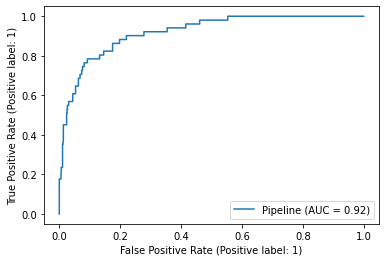

In [331]:
plot_roc_curve(pipeline, X_oot, y_oot)

In [332]:
from utils.metrics import find_inflection_point


In [333]:
scores = y_pred_prob_oot
scores = pd.DataFrame(scores)

scores['y'] = y_oot.values
scores_sorted = scores.sort_values(1, ascending=False)[[1, 'y']]
scores_sorted['cum_recall'] = scores_sorted['y'].cumsum()
scores_sorted['position'] = range(1, scores_sorted.shape[0]+1)
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]+1

scores.sort_values(1, ascending=False).head(10)

0         1  y
58   0.002341  0.997659  1
730  0.002495  0.997505  1
518  0.002935  0.997065  1
53   0.002935  0.997065  1
632  0.002935  0.997065  1
603  0.002935  0.997065  1
347  0.003765  0.996235  1
508  0.003765  0.996235  1
474  0.003765  0.996235  1
18   0.003801  0.996199  0

In [334]:
scores_sorted['recall_diff'] = scores_sorted['recall_at'].diff()
scores_sorted['position_diff'] = scores_sorted['adj_position'].diff()

scores_sorted.fillna(0, inplace=True)

scores_sorted['derivative'] = scores_sorted['position_diff']  / (scores_sorted['recall_diff']+1e-6)
scores_sorted['sum_derivative'] = scores_sorted['derivative'].cumsum()

scores_sorted.sort_values(1, ascending=False).head(10)

1  y  cum_recall  position  recall_at  adj_position  recall_diff  \
58   0.997659  1           1         1   0.019608      1.001252     0.000000   
730  0.997505  1           2         2   0.039216      1.002503     0.019608   
518  0.997065  1           3         3   0.058824      1.003755     0.019608   
53   0.997065  1           4         4   0.078431      1.005006     0.019608   
632  0.997065  1           5         5   0.098039      1.006258     0.019608   
603  0.997065  1           6         6   0.117647      1.007509     0.019608   
347  0.996235  1           7         7   0.137255      1.008761     0.019608   
508  0.996235  1           8         8   0.156863      1.010013     0.019608   
474  0.996235  1           9         9   0.176471      1.011264     0.019608   
18   0.996199  0           9        10   0.176471      1.012516     0.000000   

     position_diff   derivative  sum_derivative  
58        0.000000     0.000000        0.000000  
730       0.001252     0.063827        0.063827  
518       0.001252     0.063827        0.127653  
53        0.001252     0.063827        0.191480  
632       0.001252     0.063827        0.255306  
603       0.001252     0.063827        0.319133  
347       0.001252     0.063827        0.382959  
508       0.001252     0.063827        0.446786  
474       0.001252     0.063827        0.510612  
18        0.001252  1251.564456     1252.075068

In [335]:
scores_sorted['recall_at'] = scores_sorted['cum_recall'] / scores_sorted['y'].sum()
scores_sorted['adj_position'] = scores_sorted['position'] / scores_sorted.shape[0]

<AxesSubplot:title={'center':'Кумулятивный recall'}, xlabel='adj_position'>

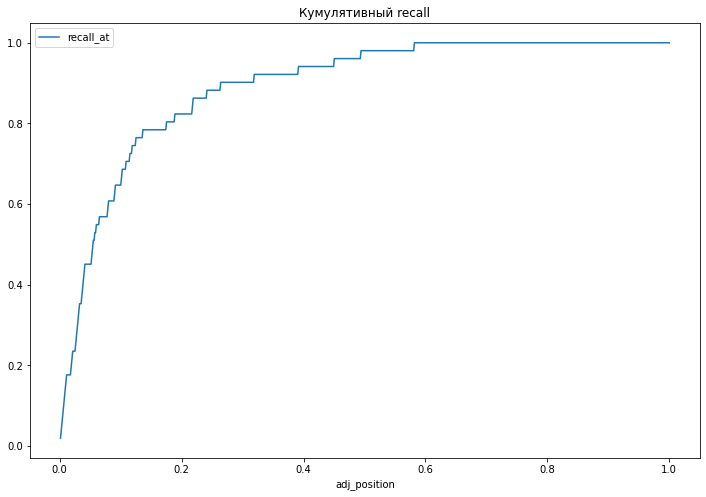

In [336]:
scores_sorted.plot(x='adj_position', y='recall_at', figsize=(12,8), title='Кумулятивный recall')

In [337]:
cutoff = find_inflection_point(scores_sorted, 5, 4, 801, step=25)

In [338]:
cutoff

137

In [339]:
cutoff = cutoff / scores_sorted.shape[0]

<h4>Формирование сегмента клиентов для пилота</h4>

In [340]:
score_date = '2019-08-14'

In [341]:
X_score = get_feature_matrix(orders_df=orders_df,
                               date=score_date,
                               demogr_df=demographics)

In [342]:
scores = pipeline.predict_proba(X_score)

In [343]:
score_df = pd.DataFrame()
score_df['customer_id'] = X_score.user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [344]:
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

array([2292, 1627, 1841,  314, 1468, 1572, 1031,   48, 2173,  939,  264,
        242, 1363,  748,  201, 1257, 1939, 1949, 2397,  370, 1680,  170,
       2181, 1649,  248,  391, 2272, 2494,   86, 1537,  309,  283, 1919,
        875, 1861, 1391, 1753,  685, 1923, 1226, 1953, 1726,  785, 1076,
        607, 2193,  708, 1300, 2179,  118, 2186,  914, 2040,  560, 1979,
        317, 1261,  114, 1749,  473, 1367, 1536,  221,  968,  879,  257,
        752, 1376, 1159, 1578, 2231, 1850,  898,  301,  973,  586, 1268,
       2499,  802, 2024,   40,  411,  282, 1759, 1948,  803, 1800,  385,
        624, 2134,  276,  682,   13,  518, 1937, 2063, 1634,  609,   31,
       2111, 1437,  121,  865,  867,  630, 1041, 1802, 1443, 2100, 1529,
       1147, 1709,   46, 2006, 1524, 1038,  680, 1990,  442, 1070, 2243,
       1648, 1980, 1004,   58, 1899,  755, 1585, 1419,   39,   49, 1318,
       1609,  979, 1795,  605, 1764,  104])

<h3>Домашнее задание 1</h3>
<br>
Измените функцию get_target так, чтобы она использовала взвешенную оценку статистической значимости последнего простоя.

<b><i>Подсказка:</i></b> передавайте функцию для оценки статистической значимости в качестве аргумента функции get_target.

<h3>Домашнее задание 2</h3>
<br>
Добавьте в витрину признаки коммуникации и сравните результат обучения модели с текущим<br>

<b><i>Подсказка:</i></b> Можно использовать код из лекции, посвященной слонности клиентов к коммуникации.

<br>
<h1>Практика 5</h1>
<h3>Построение модели реактивации</h3>
<br>

In [345]:
react_path       = os.path.join(_PATH, 'day_4_reactivation.csv') # информация о заказах, сгруппированная по корзинам
react_campaign_path = os.path.join(_PATH, 'day_4_reactivation_info.csv') # информация о клиентах, использовавших купон реактивации

In [346]:
react_df = pd.read_csv(react_path)
react_campaign_df = pd.read_csv(react_campaign_path)

In [347]:
react_df['purch_date_time'] = react_df['purch_date_time'].astype(np.datetime64)
react_campaign_df['day'] = react_campaign_df['day'].astype(np.datetime64)

In [348]:
react_df.head()

user_id    basket_id     purch_date_time  quantity  sales_value  \
0        1  27601281299 2018-09-19 15:56:00        34        78.66   
1        1  27774192959 2018-10-05 21:02:00        14        41.10   
2        1  28024266849 2018-10-26 17:04:00        13        26.90   
3        1  28106322445 2018-11-01 20:37:00        32        63.43   
4        1  28235481967 2018-11-08 17:03:00        20        53.45   

   retail_disc  default_price  
0       -16.54          96.20  
1        -8.59          49.69  
2        -6.72          33.62  
3       -11.08          76.51  
4       -16.42          69.87

In [349]:
react_campaign_df.head()

user_id                 day       coupon_upc  campaign
0     1707 2019-08-14 20:58:00  999000111000999        99
1      411 2019-08-15 00:06:00  999000111000999        99
2     1229 2019-08-12 15:00:00  999000111000999        99
3      567 2019-08-16 01:16:00  999000111000999        99
4     2260 2019-08-23 18:26:00  999000111000999        99

In [350]:
start_period = dt.datetime.strptime('2019-07-29', '%Y-%m-%d') 
end_period = start_period + dt.timedelta(days=14)
end_period

datetime.datetime(2019, 8, 12, 0, 0)

In [351]:
cut_date = '2019-07-29'

In [352]:
from utils.data_prep import get_feature_matrix

feature_matrix = get_feature_matrix(orders_df=react_df,
                                    date=cut_date,
                                    demogr_df=demographics)

In [353]:
# Соберем информацию о клиентах, которых можно считать отточниками на основании бизнес-правила (хотя бы одна покупка за прошледшие 30 дней и ни одной - в течение последних 14 дней)

In [354]:
# сначала соберем информацию клиентах, активных в препериоде
preperiod = start_period - dt.timedelta(days=30)
acitve_users_preperiod = react_df[(react_df.purch_date_time >= preperiod) & (react_df.purch_date_time <= start_period)].user_id.unique()

In [355]:
# потом соберем клиентов, неактивных в течение последующих 14 дней
acitve_users = react_df[(react_df.purch_date_time >= start_period) & (react_df.purch_date_time <= end_period)].user_id.unique()

In [356]:
# теперь получим разность множеств
churn_users = set(acitve_users_preperiod) - set(acitve_users)
len(churn_users)

438

<h3>Домашнее задание 3</h3>
<br>
Расчитайте для указанных клиентов статистическую значимость постоя в 14 дней на основе любого из предложенных методов<br>

<b><i>Подсказка:</i></b> В качестве даты среза используйте '2019-8-12'.

In [357]:
target = pd.DataFrame()
target['user_id'] = react_campaign_df.user_id.values
target['y'] = 1

In [358]:
df = feature_matrix[feature_matrix.user_id.isin(churn_users)]
df = df.merge(target, how='left')
df['y'] = df['y'].fillna(0).astype('int8') 
df.sample(10)

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
51     2006    45-54   Under 15K     True                   7.0   
17      685    35-44   Under 15K     True                   4.0   
24      914    45-54      15-24K     True                   4.0   
48     1953    45-54      50-74K    False                   2.0   
8       248    35-44    125-149K    False                   NaN   
46     1948    35-44      50-74K     True                  20.0   
28     1076    25-34      35-49K     True                   1.0   
2       134    55-64      25-34K     True                  19.0   
19      785      65+      75-99K     True                   5.0   
34     1364      65+    100-124K     True                  28.0   

    quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
51                   7.0               7.000000                      7.0   
17                   4.0               4.000000                      4.0   
24                   4.0               4.000000                      4.0   
48                  45.0              11.833333                      6.0   
8                    NaN                    NaN                      NaN   
46                  20.0              20.000000                     20.0   
28                   1.0               1.000000                      1.0   
2                   28.0              23.500000                     23.5   
19                   5.0               5.000000                      5.0   
34                  28.0              28.000000                     28.0   

    quantity_std_14_days  quantity_sum_14_days  ...  \
51                   NaN                   7.0  ...   
17                   NaN                   4.0  ...   
24                   NaN                   4.0  ...   
48             16.533804                  71.0  ...   
8                    NaN                   NaN  ...   
46                   NaN                  20.0  ...   
28                   NaN                   1.0  ...   
2               6.363961                  47.0  ...   
19                   NaN                   5.0  ...   
34                   NaN                  28.0  ...   

    default_price_mean_60_days  default_price_median_60_days  \
51                   42.266667                        24.740   
17                   36.307692                        27.440   
24                   48.996000                         7.740   
48                   35.581250                        19.340   
8                   266.400000                       266.400   
46                   25.887500                        28.335   
28                   17.035556                        13.030   
2                    70.624000                        70.820   
19                   10.755000                        10.755   
34                   20.293333                         6.870   

    default_price_std_60_days  default_price_sum_60_days  \
51                  35.661477                     126.80   
17                  24.797702                     472.00   
24                  68.764021                     244.98   
48                  40.599215                     853.95   
8                         NaN                     266.40   
46                  14.994469                     103.55   
28                  12.608107                     153.32   
2                   12.306530                     353.12   
19                   4.857824                      21.51   
34                  26.375392                     182.64   

    default_price_vals_range_60_days  default_price_quantile_25_60_days  \
51                             64.54                            21.7500   
17                             76.27                            15.4100   
24                            157.77                             2.6500   
48                            152.76                            11.8325   
8                               0.00                           266.4000   
46     

In [359]:
df.y.value_counts()

0    53
1    18
Name: y, dtype: int64

In [360]:
X = df.drop(['user_id', 'y'], axis=1)
y = df.y

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [362]:
categorical_features = X.select_dtypes(exclude=['Int64', 'float64']).columns.values
numeric_features = [feature for feature in list(X.columns) if feature not in categorical_features]

In [363]:
pipeline = create_pipeline(cat_features=categorical_features,
                          numer_features=numeric_features,
                          model=LGBMClassifier(objective = "binary", random_state = 42, is_unbalance=True))

In [364]:
best = param_search(pipeline, X_train, y_train, search_space)

100%|██████████| 100/100 [00:09<00:00, 10.04trial/s, best loss: -0.5416666666666667]


In [365]:
best_params = unpack_model_params(best)
pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['age_desc', 'income_desc', 'no_kids'], dtype=object))])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.4967170204033949, max_depth=9,
                                n_estimators=900, n_jobs=8, num_leaves=88,
                                objective='binary', random_state=42,
                                reg_alpha=0.12518424979537002,
                                reg_lambda=0.848500137428167))])

In [366]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['quantity_min_14_days',
                                                   'quantity_max_14_days',
                                                   'quantity_mean_14_days',
                                                   'quantity_median_14_days',
                                                   'quantity_std_14_days',
                                                   'quantity_sum_14_days',
                                                   'quantity_vals_range_14_days',
                                                   'quantity_quantile_25_14_day...
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['age_desc', 'income_desc', 'no_kids'], dtype=object))])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.4967170204033949, max_depth=9,
                                n_estimators=900, n_jobs=8, num_leaves=88,
                                objective='binary', random_state=42,
                                reg_alpha=0.12518424979537002,
                                reg_lambda=0.848500137428167))])

In [367]:
prob_pred = pipeline.predict_proba(X_test)

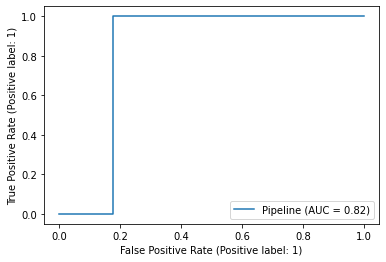

In [368]:
plot_roc_curve(pipeline, X_test, y_test)

<br>
<h1>Практика 6</h1>
<h3>Формирование сегмента на рассылку удерживающих коммуникаций</h3>
<br>

In [369]:
start_date = dt.datetime.strptime('2020-03-07', '%Y-%m-%d')  

In [370]:
mask = (orders_df.user_id.isin(demographics.user_id) & (orders_df.purch_date_time <= start_date))

In [371]:
# получим 50 % клиентов с худшими скорами на текущий момент (точнее, на момент последнего отраженного в выборке наблюдения)
transaction_data = summary_data_from_transaction_data(transactions=orders_df.loc[mask],
                                                      customer_id_col='user_id',
                                                      datetime_col='purch_date_time',
                                                      monetary_value_col='sales_value',
                                                      freq='D') 

In [372]:
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(transaction_data['frequency'], 
        transaction_data['recency'], 
        transaction_data['T'])
bgf.summary

coef      se(coef)  lower 95% bound  upper 95% bound
r      1.343089e+00  4.820984e-02     1.248598e+00     1.437580e+00
alpha  6.210093e+00  2.932009e-01     5.635419e+00     6.784767e+00
a      3.979097e-16  3.066178e-12    -6.009311e-12     6.010107e-12
b      1.188881e-05  5.586591e-02    -1.094853e-01     1.095091e-01

In [373]:
transaction_data = transaction_data.reset_index()

In [374]:
transaction_data['p_alive'] = bgf.conditional_probability_alive(transaction_data['frequency'], transaction_data['recency'], transaction_data['T'])

In [375]:
for_communication = transaction_data[transaction_data['p_alive'] <= transaction_data['p_alive'].median()][['user_id', 'p_alive']]

<h3>Домашнее задание 4</h3>
<br>
Расчитайте для клиентов с анкетными данными значмость текущего открытого интервала и в качестве выборки возьмите 25 процентов клиентов с худшими скорами
<br>

<b><i>Подсказка:</i></b> Для получения значения границы нижнего квартиля можно использовать метод pandas .quanile() с соответствующим значением аргумента.

In [376]:
# загрузим модель отклика, обученную в ходе прошлой практики
import pickle
_FILEPATH = os.path.join(os.path.dirname(os.getcwd()), 'references', 'models', 'day_3_model_response.pkl')

with open(_FILEPATH, 'rb') as pickle_file:
    fitted_model = pickle.load(pickle_file)

In [377]:
# для удобства используем собранную на прошлом занятии витрину
data_mart_path = os.path.join(_PATH, 'day_4_datamart.csv')
data_mart = pd.read_csv(data_mart_path)
data_mart.head()

user_id age_desc income_desc  no_kids  quantity_min_14_days  \
0        1      65+      35-49K     True                  11.0   
1        7    45-54      50-74K     True                  13.0   
2        8    25-34      25-34K    False                   1.0   
3       13    25-34      75-99K    False                   2.0   
4       16    45-54      50-74K     True                   3.0   

   quantity_max_14_days  quantity_mean_14_days  quantity_median_14_days  \
0                  11.0              11.000000                     11.0   
1                  13.0              13.000000                     13.0   
2                9438.0            3156.000000                     29.0   
3               24877.0            8408.428571                     53.0   
4                   7.0               5.000000                      5.0   

   quantity_std_14_days  quantity_sum_14_days  ...  \
0                   NaN                  11.0  ...   
1                   NaN                  13.0  ...   
2           5440.389600                9468.0  ...   
3          10793.009495               58859.0  ...   
4              2.828427                  10.0  ...   

   default_price_median_60_days  default_price_std_60_days  \
0                         21.18                  48.553133   
1                         92.87                  45.756704   
2                         23.32                  44.045991   
3                         37.57                  57.909649   
4                         14.99                   6.330213   

   default_price_sum_60_days  default_price_vals_range_60_days  \
0                     397.87                            112.27   
1                     454.27                            112.93   
2                     652.16                            167.68   
3                    1350.62                            203.46   
4                      44.79                             12.66   

   default_price_quantile_25_60_days  default_price_quantile_75_60_days  \
0                               6.67                             103.89   
1                              71.06                             128.37   
2                              19.13                              47.26   
3                              21.62                              59.43   
4                              11.78                              18.11   

   default_price_interquantile_range_60_days  default_price_skewness_60_days  \
0                                      97.22                        0.765882   
1                                      57.31                       -0.633524   
2                                      28.13                        2.346431   
3                                      37.81                        1.531430   
4                                       6.33                       -0.042649   

   prev_communication  prev_response  
0                   1              1  
1                   1              0  
2                   1              1  
3                   1              1  
4                   1              0  

[5 rows x 138 columns]

In [378]:
# отфильтруем только нужных пользователей
X_score = data_mart[data_mart.user_id.isin(for_communication.user_id)].drop(columns=['user_id'], axis=1)

In [379]:
scores = fitted_model.predict_proba(X_score)

In [380]:
# соберем скоры
score_df = pd.DataFrame()
score_df['customer_id'] = data_mart[data_mart.user_id.isin(for_communication.user_id)].user_id
score_df['report_date'] = dt.date.today()
score_df['score'] = scores[:,1]

In [381]:
cutoff = 0.056 # нашли на прошлом занятии точку перегиба для данной модели

In [382]:
# наш топ клиентов, в отношении которых предполагается принять некоторые маркетинговые усилия
score_df.sort_values('score', ascending=False).iloc[:int(cutoff * score_df.shape[0]) +1, 0].values

array([ 764,  184,  418,  934, 1453, 2407,  712, 1428, 1179, 2334, 1421,
       1367, 1944, 2496,  725,   40,  696,  883,   67, 2467, 2378,  979,
        770,  170,  389,  761,  630,  113,  219,  864, 2280, 1451, 1764,
        438, 1568,  101, 1653, 1357,  218, 2351, 1529, 1197, 2360, 1864,
       2264])

<br>
<h1>Практика 7</h1>
<h3>Оценка значимости наблюдаемых значений метрики - развитие подхода</h3>
<br>

<h3>Прогноз количества покупок (с разной длительностью кампании)</h3>

In [383]:
# используем датафрейм, который использовали для обучения модели по предсказанию оттока
ord_pred = bgf_churn.copy()
ord_pred.drop('p_alive', axis=1, inplace=True)

In [384]:
ord_pred.head()

user_id  frequency  recency      T
0        1       30.0    286.0  299.0
1        2       27.0    242.0  247.0
2        3       26.0    207.0  237.0
3        4       17.0    237.0  246.0
4        5       17.0    249.0  265.0

In [385]:
# используем модель, чтобы спрогнозировать количество заказов в ближайшие 14 дней
t = 14
ord_pred['pred_purch_14_days'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                         ord_pred['frequency'],
                                                                                         ord_pred['recency'],
                                                                                         ord_pred['T'])
ord_pred.sort_values(by='pred_purch_14_days').tail(5)

user_id  frequency  recency      T  pred_purch_14_days
1793     1795      200.0    261.0  261.0           10.549015
1509     1510      206.0    267.0  268.0           10.586055
1418     1419      218.0    281.0  282.0           10.654739
2455     2459      251.0    314.0  315.0           10.998419
2333     2337      210.0    236.0  236.0           12.215854

In [386]:
# округлим до целых чисел
ord_pred['pred_purch_14_days_round'] = ord_pred['pred_purch_14_days'].round()

In [387]:
# проверим качество работы модели
start_day = dt.datetime.strptime('2019-07-15', '%Y-%m-%d')
end_day = start_day + dt.timedelta(days=14)

In [388]:
orders_true = orders_df[(orders_df['purch_date_time'] > start_day) \
          & (orders_df['purch_date_time'] <= end_day)].groupby('user_id')['basket_id'].count().reset_index().rename({'basket_id':'num_ord_14_days'}, axis=1)

In [389]:
orders_true.head()

user_id  num_ord_14_days
0        1                2
1        3                1
2        4                4
3        6                8
4        8                3

In [390]:
ord_pred = ord_pred.merge(orders_true, how='left')
ord_pred['num_ord_14_days'] = ord_pred['num_ord_14_days'].fillna(0).astype('int')

In [391]:
# посмотрим, насколько мы ошиблись в прогнозе (округлим прогноз до целых дней)
ord_pred['diff_14_day'] = ord_pred['num_ord_14_days'] - ord_pred['pred_purch_14_days_round']
ord_pred['diff_14_day'].describe()

count    2497.000000
mean        0.466960
std         2.418008
min        -8.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        31.000000
Name: diff_14_day, dtype: float64

In [392]:
from sklearn.metrics import mean_squared_error

In [393]:
# посчитаем среднеквадратичную ошибку
mse_14_days = mean_squared_error(ord_pred.num_ord_14_days, ord_pred.pred_purch_14_days_round)
print(mse_14_days)

6.062474969963957


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

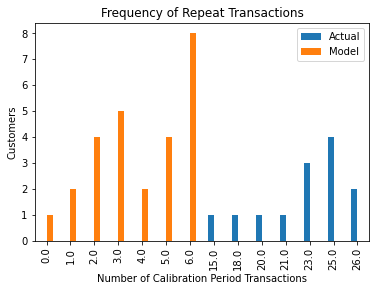

In [394]:
plot_period_transactions(bgf)

In [395]:
# то есть, мы имеем медианное отклонение в районе нуля и MSE в районе 6
ord_pred.sample(10)

user_id  frequency  recency      T  pred_purch_14_days  \
1985     1988       57.0    277.0  277.0            2.884089   
1475     1476      126.0    315.0  315.0            5.550272   
1937     1939       22.0    308.0  331.0            0.969138   
324       325       30.0    273.0  279.0            1.538526   
1816     1818       28.0    188.0  335.0            1.203960   
1285     1286       18.0    271.0  298.0            0.890185   
1154     1155        7.0    272.0  276.0            0.413888   
486       487        0.0      0.0  248.0            0.073967   
328       329       58.0    271.0  271.0            2.997017   
2197     2200       85.0    342.0  343.0            3.461536   

      pred_purch_14_days_round  num_ord_14_days  diff_14_day  
1985                       3.0                7          4.0  
1475                       6.0                3         -3.0  
1937                       1.0                0         -1.0  
324                        2.0                2          0.0  
1816                       1.0                0         -1.0  
1285                       1.0                0         -1.0  
1154                       0.0                1          1.0  
486                        0.0                0          0.0  
328                        3.0                3          0.0  
2197                       3.0                5          2.0

In [396]:
# используем модель, чтобы спрогнозировать количество заказов в ближайшие 21 день
t = 21
ord_pred['pred_purch_21_days'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                         ord_pred['frequency'],
                                                                                         ord_pred['recency'],
                                                                                         ord_pred['T'])
ord_pred.sort_values(by='pred_purch_21_days').tail(5)

user_id  frequency  recency      T  pred_purch_14_days  \
1793     1795      200.0    261.0  261.0           10.549015   
1509     1510      206.0    267.0  268.0           10.586055   
1418     1419      218.0    281.0  282.0           10.654739   
2455     2459      251.0    314.0  315.0           10.998419   
2333     2337      210.0    236.0  236.0           12.215854   

      pred_purch_14_days_round  num_ord_14_days  diff_14_day  \
1793                      11.0               25         14.0   
1509                      11.0               33         22.0   
1418                      11.0               20          9.0   
2455                      11.0               25         14.0   
2333                      12.0               43         31.0   

      pred_purch_21_days  
1793           15.823522  
1509           15.879083  
1418           15.982108  
2455           16.497629  
2333           18.323782

In [397]:
ord_pred.pred_purch_21_days.isnull().sum()

0

In [398]:
ord_pred['pred_purch_21_days_round'] = ord_pred['pred_purch_21_days'].round()

In [399]:
# проверим качество работы модели
start_day = dt.datetime.strptime('2019-07-15', '%Y-%m-%d')
end_day = start_day + dt.timedelta(days=21)

orders_true = orders_df[(orders_df['purch_date_time'] > start_day) \
          & (orders_df['purch_date_time'] <= end_day)].groupby('user_id')['basket_id'].count().reset_index().rename({'basket_id':'num_ord_21_days'}, axis=1)

In [400]:
ord_pred = ord_pred.merge(orders_true, how='left')
ord_pred['num_ord_21_days'] = ord_pred['num_ord_21_days'].fillna(0).astype('int')

In [401]:
# посмотрим, насколько мы ошиблись в прогнозе (округлим прогноз до целых дней)
ord_pred['diff_21_day'] = ord_pred['num_ord_21_days'] - ord_pred['pred_purch_21_days_round']
ord_pred['diff_21_day'].describe()

count    2497.000000
mean        0.616740
std         3.360321
min       -11.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        48.000000
Name: diff_21_day, dtype: float64

In [402]:
# логично: растет окно - увеличивается расхождение прогнозных данных с реальными, так как поведение пользователей меняется динамически
mse_21_days = mean_squared_error(ord_pred.num_ord_21_days, ord_pred.pred_purch_21_days_round.fillna(0))
print(mse_21_days)

11.667601121345614
